# 1. Imports

## 1.1 Libs

In [1]:
import pickle
import inflection
import datetime
import sqlite3

import pandas               as pd
import numpy                as np
import seaborn              as sns
import xgboost              as xgb

from matplotlib             import pyplot                   as plt
from sklearn                import ensemble                 as en

from boruta                 import BorutaPy
from sqlalchemy             import create_engine
from sklearn.ensemble       import RandomForestRegressor
from sklearn.linear_model   import LinearRegression, Lasso
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics        import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error


## 1.2 Loding Data

In [57]:
# Database Conection

host = 'irish-sea-db.cyllx5pgzqdx.us-east-1.rds.amazonaws.com'
port = '5432'
database = 'postgres'
user = 'postgres'
pwd = 'dadosfera'

endpoint_aws = f'postgresql://{user}:{pwd}@{host}/{database}'

engine = create_engine(endpoint_aws)
connection = engine.connect()

# Consulting Database
query = """ 
    SELECT * FROM wave
"""

df1 = pd.read_sql_query(query, engine)

connection.close()

## 1.3 Helper Function

In [3]:
def cross_validation (x_training, kfold, model_name, model, verbose=False):

    mae_list = []
    mape_list = []
    rsme_list = []

    for k in reversed(range(1, kfold+1)):
        if verbose:
            print(f'KFold Number: {k}')
 
        # start and end date for validation
        validation_start_date = x_training['time'].max() - datetime.timedelta(days = k*3*30)
        validation_end_date = x_training['time'].max() - datetime.timedelta(days = (k-1)*3*30)

        # filtering dataset
        training = x_training[ x_training['time'] < validation_start_date]
        validation = x_training[(x_training['time'] >= validation_start_date) & (x_training['time'] <= validation_end_date)]

        # training and validation dataset
        xtraining = training.drop(['time', 'sea_temperature'], axis = 1)
        ytraining = training['sea_temperature']

        xvalidation = validation.drop(['time', 'sea_temperature'], axis=1)
        yvalidation = validation['sea_temperature']

        # model
        m = model.fit(xtraining, ytraining)
        # prediction
        yhat = m.predict(xvalidation)
        # performance
        m_result = ml_error(model_name, yvalidation, yhat)
        
        #store performance of each kfold iteration
        mae_list.append (m_result['MAE'])   
        mape_list.append(m_result['MAPE'])
        rsme_list.append(m_result['RSME'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV':  np.round( np.mean( mae_list ), 3).astype(str)  + ' +/- ' + np.round(np.std(mae_list), 3).astype(str),
                         'MAPE CV': np.round( np.mean( mape_list ), 3).astype(str) + ' +/- ' + np.round(np.std(mape_list), 3).astype(str),
                         'RSME CV': np.round( np.mean( rsme_list ), 3).astype(str) + ' +/- ' + np.round(np.std(rsme_list), 3).astype(str)}, index = [0])

def numerical_metrics(numerical_attributes):
    #ct = central tendency
    ct_mean = pd.DataFrame(numerical_attributes.apply(np.mean)).T
    ct_median = pd.DataFrame(numerical_attributes.apply(np.median)).T

    #d = dispersion
    d_std = pd.DataFrame(numerical_attributes.apply(np.std)).T
    d_min = pd.DataFrame(numerical_attributes.apply(min)).T
    d_max = pd.DataFrame(numerical_attributes.apply(max)).T
    d_range = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
    d_skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
    d_kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

    concat = pd.concat([d_min,d_max,d_range,ct_mean,ct_median,d_std,d_skew,d_kurtosis]).T.reset_index()
    concat.columns=['Attributes','Min','Max','Range','Mean','Median','STD','Skew','Kurtosis']

    return concat

def ml_error (model_name, y, yhat): 
    mae  = mean_absolute_error (y, yhat)
    mape = mean_absolute_percentage_error (y, yhat)
    rsme = np.sqrt(mean_squared_error (y, yhat))

    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RSME': rsme}, index=[0]) 

# 2. Data Understanding

## 2.1 Overview

### 2.1.1 Basic Data Structure

In [4]:
df2 = df1.copy()

In [5]:
df2.head()

,longitude,latitude,time,station_id,PeakPeriod,PeakDirection,UpcrossPeriod,SignificantWaveHeight,Hmax,SeaTemperature,MeanCurSpeed,MeanCurDirTo
0,degrees_east,degrees_north,UTC,None,s,degrees_true,s,cm,cm,degree_C,m/s,degrees_true
1,-10.29737,54.2753,2021-09-01T00:22:00Z,AMETS Berth A Wave Buoy,4.76,30.9,4.04,87.0,None,15.7,None,None
2,-10.29737,54.2753,2021-09-01T00:52:00Z,AMETS Berth A Wave Buoy,4.35,35.2,3.846,84.0,None,15.55,None,None
3,-10.29737,54.2753,2021-09-01T01:22:00Z,AMETS Berth A Wave Buoy,4.55,30.9,3.922,86.0,None,15.35,None,None
4,-10.29737,54.2753,2021-09-01T01:52:00Z,AMETS Berth A Wave Buoy,4.35,30.9,3.883,81.0,None,15.4,None,None


In [6]:
# Remove the header of dataset
df2 = df2[~df2['time'].str.contains('UTC', na=False)]

In [7]:
print(f'Number of Rows:{df2.shape[0]}')
print(f'Number of Columns:{df2.shape[1]}')

Number of Rows:258391
Number of Columns:12


In [8]:
df2.dtypes

longitude                object
latitude                 object
time                     object
station_id               object
PeakPeriod               object
PeakDirection            object
UpcrossPeriod            object
SignificantWaveHeight    object
Hmax                     object
SeaTemperature           object
MeanCurSpeed             object
MeanCurDirTo             object
dtype: object

### 2.1.1 Features Definition

| Feature                    | Definition
|----------------------------|---------------------------------------------------------------|
| longitude                  | Geolocation                                                   |                                                                   
| latitude                   | Geolocation                                                   |       
| time                       | Datetime when the row was registred                           |                               
| station_id                 | Station Name                                                  |       
| peak_period                | Time (in seconds) that the wave remained at the peak          |                                               
| peak_direction             | object                                                        |   
| upcross_period             | Time (in seconds)                                             |               
| significant_wave_height    | Wave Height (in cm)                                           |               
| hmax                       | Height máx (in cm)                                            |               
| sea_temperature            | Temperature em celcius degree                                 |                           
| mean_cur_speed             | Wave Speed (in m/s)                                           |               
| mean_cur_dir_to            | object                                                        |   

### 2.1.2 Data Summary

| Station   | ID                        | Analyzed Period                                       | Information    |
|-----------|---------------------------|-------------------------------------------------------|----------------| 
| 1 | AMETS Berth A Wave Buoy   | Start: 2021-09-01 00:22:00 - End: 2022-08-31 23:35:00 | Record every 30 minutes, doesn't have information about hmax, mean_cur_speed and mean_cur_dir_to|                         
| 2 | AMETS Berth B Wave Buoy   | Start: 2021-09-01 00:02:00 - End: 2022-08-31 23:32:00 | Record every 30 minutes, doesn't have information about hmax, mean_cur_speed and mean_cur_dir_to|                              
| 3 | Bantry Bay                | Start: 2021-09-01 00:00:00 - End: 2022-08-13 07:00:00 | Temperature information is recorded every 5 minutes, wave information every 30 minutes, doesn't have information about speed and direction.|                  
| 4 | Brandon Bay               | Start: 2021-09-01 00:00:00 - End: 2022-03-04 05:30:00 | Temperature information is recorded every 5 minutes, wave information every 30 minutes, doesn't have information about speed and direction.|                  
| 5 | Clew Bay                  | Start: 2021-10-30 00:03:00 - End: 2022-08-25 12:34:00 | Record every 30 minutes, doesn't have information about hmax, mean_cur_speed and mean_cur_dir_to|              
| 6 | SmartBay Wave Buoy        | Start: 2021-09-01 00:00:00 - End: 2022-08-31 23:30:00 | Temperature information is recorded every 5 minutes, speed and direction information every 10 minutes and wave information every 30 minutes |        
| 7 | AMETS Berth C Wave Buoy   | does not have information in the analyzed period      |                          
| 8 | Westwave Wave Buoy        | does not have information in the analyzed period      |   

## 2.2 Rename Columns

In [9]:
df2.columns

Index(['longitude', 'latitude', 'time', 'station_id', 'PeakPeriod',
       'PeakDirection', 'UpcrossPeriod', 'SignificantWaveHeight', 'Hmax',
       'SeaTemperature', 'MeanCurSpeed', 'MeanCurDirTo'],
      dtype='object')

In [10]:
cols_old = ['longitude', 'latitude', 'time', 'station_id', 'PeakPeriod',
       'PeakDirection', 'UpcrossPeriod', 'SignificantWaveHeight', 'Hmax',
       'SeaTemperature', 'MeanCurSpeed', 'MeanCurDirTo']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map(snakecase, cols_old))

df2.columns = cols_new

df2.head()

,longitude,latitude,time,station_id,peak_period,peak_direction,upcross_period,significant_wave_height,hmax,sea_temperature,mean_cur_speed,mean_cur_dir_to
1,-10.29737,54.2753,2021-09-01T00:22:00Z,AMETS Berth A Wave Buoy,4.76,30.9,4.04,87.0,None,15.7,None,None
2,-10.29737,54.2753,2021-09-01T00:52:00Z,AMETS Berth A Wave Buoy,4.35,35.2,3.846,84.0,None,15.55,None,None
3,-10.29737,54.2753,2021-09-01T01:22:00Z,AMETS Berth A Wave Buoy,4.55,30.9,3.922,86.0,None,15.35,None,None
4,-10.29737,54.2753,2021-09-01T01:52:00Z,AMETS Berth A Wave Buoy,4.35,30.9,3.883,81.0,None,15.4,None,None
5,-10.29737,54.2753,2021-09-01T02:22:00Z,AMETS Berth A Wave Buoy,5.26,21.1,3.883,79.0,None,15.35,None,None


## 2.3 Check and Fillout NA

In [11]:
df3 = df2.copy()

In [12]:
df3.isna().sum()

longitude                       0
latitude                        0
time                            0
station_id                      0
peak_period                179101
peak_direction             179101
upcross_period             179101
significant_wave_height    179101
hmax                       222608
sea_temperature                 0
mean_cur_speed             206365
mean_cur_dir_to            206368
dtype: int64

In [13]:
# 3 stations doesn't have information about hmax, mean_cur_speed and mean_cur_dir_to. So this columns will be droped.
df3 = df3.drop(columns = ['hmax', 'mean_cur_speed', 'mean_cur_dir_to'], axis=1)


In [14]:
# Now, the missing values originate from the difference in the recording interval.
# The temperature is recorded every 5 minutes and the other values are recorded every 30 minutes.
df3 = df3.dropna()

In [15]:
df3.isna().sum()

longitude                  0
latitude                   0
time                       0
station_id                 0
peak_period                0
peak_direction             0
upcross_period             0
significant_wave_height    0
sea_temperature            0
dtype: int64

## 2.4 Change Types

In [16]:
df3.dtypes

longitude                  object
latitude                   object
time                       object
station_id                 object
peak_period                object
peak_direction             object
upcross_period             object
significant_wave_height    object
sea_temperature            object
dtype: object

In [17]:
# Longitude
df3['longitude'] = df3['longitude'].astype(float)

# Latitude
df3['latitude'] = df3['latitude'].astype(float)

# Time
df3['time'] = pd.to_datetime(df3['time']).dt.tz_localize(None)

# peak_period
df3['peak_period'] = df3['peak_period'].astype(float)

# peak_direction
df3['peak_direction'] = df3['peak_direction'].astype(float)

# upcross_period
df3['upcross_period'] = df3['upcross_period'].astype(float)

# significant_wave_height
df3['significant_wave_height'] = df3['significant_wave_height'].astype(float)

# sea_temperature
df3['sea_temperature'] = df3['sea_temperature'].astype(float)

In [18]:
df3.dtypes

longitude                         float64
latitude                          float64
time                       datetime64[ns]
station_id                         object
peak_period                       float64
peak_direction                    float64
upcross_period                    float64
significant_wave_height           float64
sea_temperature                   float64
dtype: object

In [19]:
df3.head()

,longitude,latitude,time,station_id,peak_period,peak_direction,upcross_period,significant_wave_height,sea_temperature
1,-10.29737,54.2753,2021-09-01 00:22:00,AMETS Berth A Wave Buoy,4.76,30.9,4.040,87.0,15.70
2,-10.29737,54.2753,2021-09-01 00:52:00,AMETS Berth A Wave Buoy,4.35,35.2,3.846,84.0,15.55
3,-10.29737,54.2753,2021-09-01 01:22:00,AMETS Berth A Wave Buoy,4.55,30.9,3.922,86.0,15.35
4,-10.29737,54.2753,2021-09-01 01:52:00,AMETS Berth A Wave Buoy,4.35,30.9,3.883,81.0,15.40
5,-10.29737,54.2753,2021-09-01 02:22:00,AMETS Berth A Wave Buoy,5.26,21.1,3.883,79.0,15.35


## 2.5 Basic Description of Data

In [20]:
num_attributes = df3.select_dtypes(include = ['float64'])

In [21]:
# Numerical Attributes
numerical_metrics(num_attributes)

,Attributes,Min,Max,Range,Mean,Median,STD,Skew,Kurtosis
0,longitude,-10.29737,-9.262278,1.035092,-9.919792,-10.094833,0.346550,0.723106,-0.697389
1,latitude,51.64700,54.275300,2.628300,53.315899,53.801353,1.039152,-0.624912,-1.251677
2,peak_period,1.22000,25.000000,23.780000,10.238369,10.530000,3.273400,-0.065485,0.366812
3,peak_direction,0.00000,359.648350,359.648350,267.896858,270.000000,55.433909,-2.463418,9.191607
4,upcross_period,1.40000,21.970000,20.570000,5.730494,5.634000,1.909862,0.315567,-0.235207
5,significant_wave_height,0.00000,1819.000000,1819.000000,182.041544,136.000000,161.609821,1.824256,4.867176
6,sea_temperature,4.51000,22.180000,17.670000,12.221870,11.980000,2.866691,0.394508,-0.827606


In [22]:
# Categorial attributes
df3[['station_id', 'sea_temperature']].groupby('station_id').count().reset_index()

,station_id,sea_temperature
0,AMETS Berth A Wave Buoy,16779
1,AMETS Berth B Wave Buoy,17049
2,Bantry Bay,16281
3,Brandon Bay,7834
4,Clew Bay,9666
5,SmartBay Wave Buoy,11681


In [23]:
# Period of time
print('Start: {}'.format(df3['time'].min()))
print('End: {}'.format(df3['time'].max()))

Start: 2021-09-01 00:00:00
End: 2022-08-31 23:35:00


# 3 Feature Engineering

## 3.1 Time-derived features

In [24]:
df4 = df3.copy()

In [25]:
# Date:
df4['date'] = df4['time'].dt.date
df4['date'] = pd.to_datetime(df4['date'])
 
# Year:
df4['year'] = df4['time'].dt.year

# Month:
df4['month'] = df4['time'].dt.month

# Year_Month
df4['year_month'] = df4['time'].dt.strftime('%Y-%m')

# Day of Month
df4['day_of_month'] = df4['time'].dt.day

# Day of Week
df4['day_of_week'] = df4['time'].dt.day_of_week

# Week of Year
df4['week_of_year'] = df4['time'].dt.weekofyear

# Hour
df4['hour'] = df4['time'].dt.hour

/tmp/ipykernel_8717/4137512259.py:21: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df4['week_of_year'] = df4['time'].dt.weekofyear


# 4 Exploratory Data Analysis

## 4.1 Univariate Analysis

### 4.1.1 Response Variable - Temperature 

In [26]:
# As the temperature had no missing values, we can use the original dataset, before excluding the NA.
df_temp = df2[['longitude', 'latitude', 'time', 'station_id', 'sea_temperature']].copy()

In [27]:
##### Change Type #####

# Longitude
df_temp['longitude'] = df_temp['longitude'].astype(float)

# Latitude
df_temp['latitude'] = df_temp['latitude'].astype(float)

# Time
df_temp['time'] = pd.to_datetime(df_temp['time']).dt.tz_localize(None)

# sea_temperature
df_temp['sea_temperature'] = df_temp['sea_temperature'].astype(float)

##### Features from time #####

# Date:
df_temp['date'] = df_temp['time'].dt.date

# Year:
df_temp['year'] = df_temp['time'].dt.year

# Month:
df_temp['month'] = df_temp['time'].dt.month

# Year_Month
df_temp['year_month'] = df_temp['time'].dt.strftime('%Y-%m')

# Save as .csv
# df_temp.to_csv('../data/sea_temperature.csv', index=False)

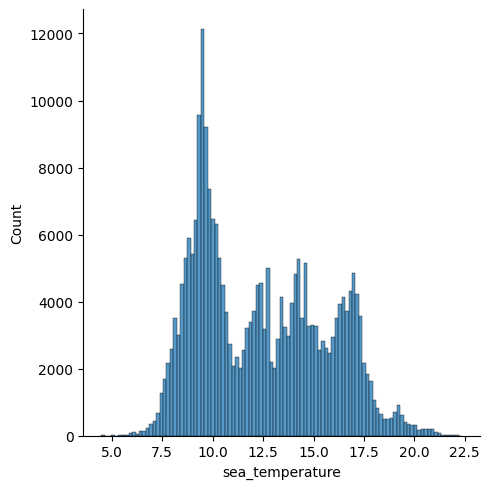

In [28]:
# Temperature Distribution
sns.displot(df_temp['sea_temperature'])

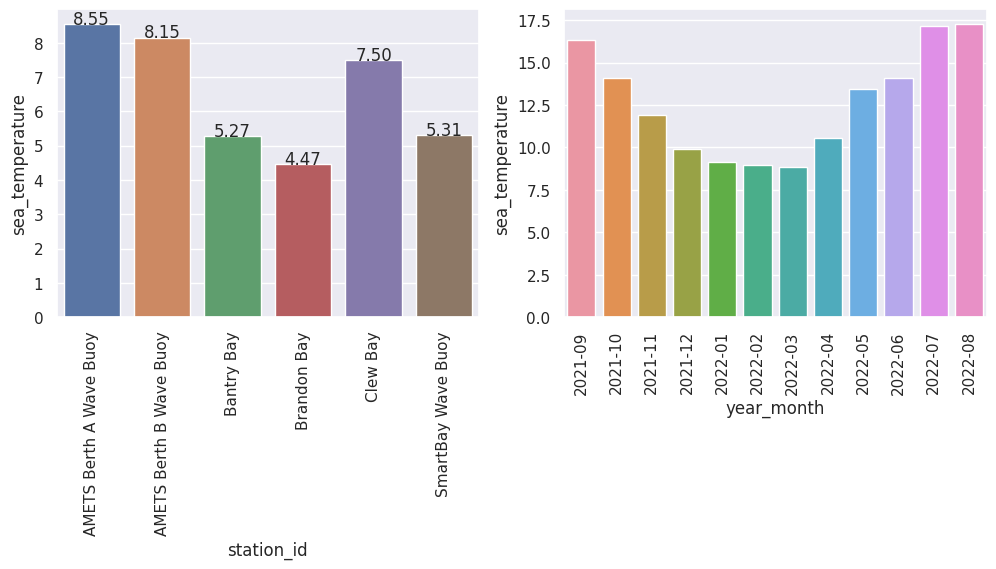

In [29]:
sns.set(rc={'figure.figsize':(12,4)})

# Average Temperature per Month
plt.subplot(1, 2, 2)
mean_temp_day = df_temp[['year_month', 'sea_temperature']].groupby('year_month').mean().reset_index()
sns.barplot(x='year_month', y='sea_temperature', data=mean_temp_day)
plt.xticks (rotation=90);

# Lowest Temperature per buoy
plt.subplot(1, 2, 1)
lowest_temp = df_temp[['station_id', 'sea_temperature']].groupby( 'station_id').min().reset_index()
# sns.barplot(x='station_id', y='sea_temperature', data = lowest_temp);
# plt.xticks (rotation=90);

plot = sns.barplot(x='station_id', y='sea_temperature', data = lowest_temp)
plt.xticks (rotation=90);
for i in plot.patches:
    height = i.get_height()
    total = len(lowest_temp['sea_temperature'])
    plot.text(i.get_x() + i.get_width()/2, 
              height,
              '{:1.2f}'.format(height),
              ha='center')

### 4.1.2 Numerical Attributes

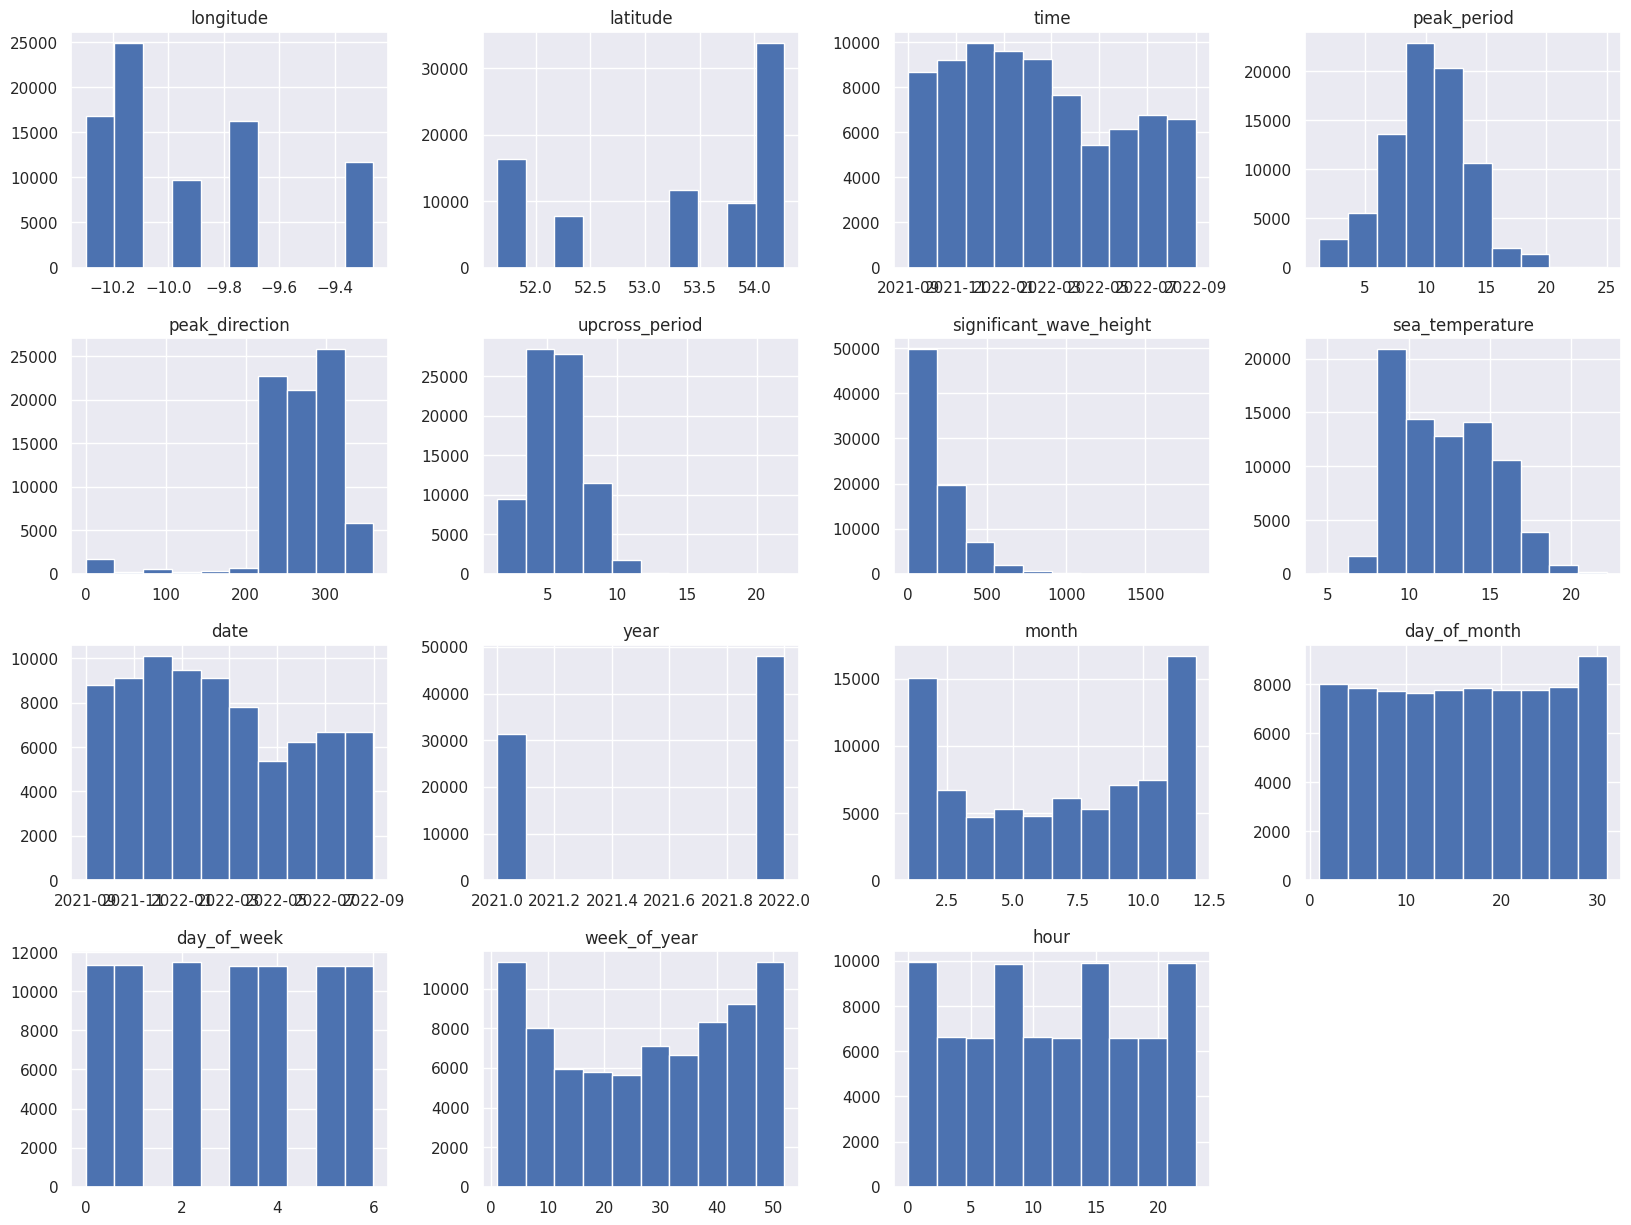

In [30]:
sns.set(rc={'figure.figsize':(20,15)})
df4.hist();

## 4.2 Bivariate Analysis

### 4.2.1 Wave Lengths vs Sea Temperature

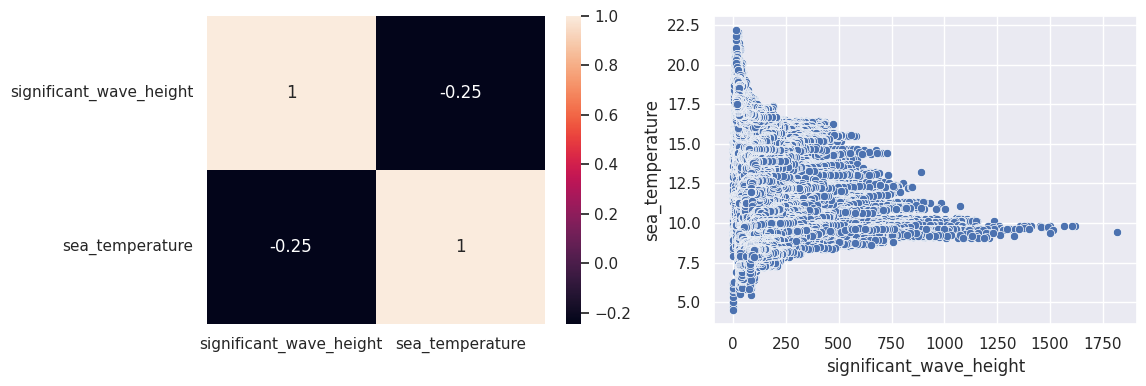

In [31]:
sns.set(rc={'figure.figsize':(12,4)})

# Scatter Plot
plt.subplot(1, 2, 2)
aux1 = df4[['significant_wave_height', 'sea_temperature']]
sns.scatterplot(data = aux1, x='significant_wave_height', y='sea_temperature')

# Correlation
plt.subplot(1, 2, 1)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

**Note:**

The correlation between Wave Length and Sea Temperature is negative, which means that with a lower temperature, there is a tendency to form larger waves.

However, by Pearson's method, this correlation presented a low index, indicating that the sea temperature does not have a very relevant impact on the size of its waves.

This indicates that using only this feature and the buoy position, it would not be possible to build a predictive model with high accuracy.

# 5 Data Preparation

## 5.1 Rescaling - Numerical Attributes

In [32]:
df5 = df4.copy()

In [33]:
mms = MinMaxScaler()
rs = RobustScaler()

# peak_period
df5['peak_period'] = mms.fit_transform(df5[['peak_period']].values)
pickle.dump(mms, open( '../parameter/peak_period_scaler.pkl', 'wb'))

# peak_direction
df5['peak_direction'] = rs.fit_transform(df5[['peak_direction']].values)
pickle.dump(rs, open( '../parameter/peak_direction_scaler.pkl', 'wb'))

# upcross_period
df5['upcross_period'] = mms.fit_transform(df5[['upcross_period']].values)
pickle.dump(mms, open( '../parameter/upcross_period_scaler.pkl', 'wb'))

# significant_wave_height
df5['significant_wave_height'] = rs.fit_transform(df5[['significant_wave_height']].values)
pickle.dump(rs, open( '../parameter/significant_wave_height_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open( '../parameter/year_scaler.pkl', 'wb'))


In [34]:
numerical_metrics(df5[['peak_period', 'peak_direction', 'upcross_period', 'significant_wave_height', 'year']])

,Attributes,Min,Max,Range,Mean,Median,STD,Skew,Kurtosis
0,peak_period,0.000000,1.000000,1.000000,0.379242,0.391505,0.137653,-0.065485,0.366812
1,peak_direction,-4.653408,1.545075,6.198484,-0.036247,0.000000,0.955395,-2.463418,9.191607
2,upcross_period,0.000000,1.000000,1.000000,0.210525,0.205834,0.092847,0.315567,-0.235207
3,significant_wave_height,-0.747253,9.247253,9.994505,0.252976,0.000000,0.887966,1.824256,4.867176
4,year,0.000000,1.000000,1.000000,0.606092,1.000000,0.488615,-0.434262,-1.811462


## 5.2 Encoding - Categorical Attributes

In [35]:
# station_id
le = LabelEncoder()
df5['station_id'] = le.fit_transform(df5['station_id'])
pickle.dump(le, open( '../parameter/station_id_scaler.pkl', 'wb'))

In [36]:
df5['station_id'].unique()

array([0, 1, 2, 3, 4, 5])

## 5.3 Nature Transformation - Cyclic Attributes

In [37]:
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x*( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x*( 2. * np.pi/12 ) ) )

# day of month
df5['day_sin'] = df5['day_of_month'].apply( lambda x: np.sin( x*( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day_of_month'].apply( lambda x: np.cos( x*( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x*( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x*( 2. * np.pi/52 ) ) )

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x*( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x*( 2. * np.pi/7 ) ) )

# hour
df5['hour_sin'] = df5['hour'].apply( lambda x: np.sin( x*( 2. * np.pi/24 ) ) )
df5['hour_cos'] = df5['hour'].apply( lambda x: np.cos( x*( 2. * np.pi/24 ) ) )

# 6. Feature Selection

## 6.1 Split Dataframe into training and test dataset

In [38]:
df6 = df5.copy()

In [39]:
cols_drop = ['longitude','latitude', 'date', 'month', 'day_of_month', 'week_of_year', 'day_of_week', 'hour']
df6 = df6.drop(cols_drop, axis=1)

In [40]:
df6.dtypes

time                       datetime64[ns]
station_id                          int64
peak_period                       float64
peak_direction                    float64
upcross_period                    float64
significant_wave_height           float64
sea_temperature                   float64
year                              float64
year_month                         object
month_sin                         float64
month_cos                         float64
day_sin                           float64
day_cos                           float64
week_of_year_sin                  float64
week_of_year_cos                  float64
day_of_week_sin                   float64
day_of_week_cos                   float64
hour_sin                          float64
hour_cos                          float64
dtype: object

In [41]:
# Training Dataset
X_train = df6[df6['year_month']<'2022-06'].reset_index(drop=True) # approximately 80% of the dataset
y_train = X_train['sea_temperature'].reset_index(drop=True)

# Validation Dataset
X_val = df6[df6['year_month']>='2022-06'].reset_index(drop=True) # approximately 20% of the dataset
y_val = X_val['sea_temperature'].reset_index(drop=True)

## 6.2 Manual Selection

Thinking about a practical application for the predictive model, where the user only has information about the date, time and the place where he would like to make the query, let's build a new model making the prediction from this information

In [42]:
cols_selected = ['station_id', 'year', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos']
cols_cv = ['station_id', 'time', 'year', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'sea_temperature']

In [43]:
# Time Series Modelling
x_train = X_train[cols_selected]
x_val = X_val[cols_selected]

# Time Series Cross Validation
x_training = df6[cols_cv].copy()

In [44]:
x_training

,station_id,time,year,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,sea_temperature
1,0,2021-09-01 00:22:00,0.0,-1.000000,-1.836970e-16,0.207912,0.978148,0.000000,1.000000,15.70
2,0,2021-09-01 00:52:00,0.0,-1.000000,-1.836970e-16,0.207912,0.978148,0.000000,1.000000,15.55
3,0,2021-09-01 01:22:00,0.0,-1.000000,-1.836970e-16,0.207912,0.978148,0.258819,0.965926,15.35
4,0,2021-09-01 01:52:00,0.0,-1.000000,-1.836970e-16,0.207912,0.978148,0.258819,0.965926,15.40
5,0,2021-09-01 02:22:00,0.0,-1.000000,-1.836970e-16,0.207912,0.978148,0.500000,0.866025,15.35
...,...,...,...,...,...,...,...,...,...,...
258367,5,2022-08-31 21:30:00,1.0,-0.866025,-5.000000e-01,0.207912,0.978148,-0.707107,0.707107,17.52
258373,5,2022-08-31 22:00:00,1.0,-0.866025,-5.000000e-01,0.207912,0.978148,-0.500000,0.866025,17.52
258379,5,2022-08-31 22:30:00,1.0,-0.866025,-5.000000e-01,0.207912,0.978148,-0.500000,0.866025,17.52
258385,5,2022-08-31 23:00:00,1.0,-0.866025,-5.000000e-01,0.207912,0.978148,-0.258819,0.965926,17.52


# 7. Machine Learning Modelling

## 7.1 Linear Regression Model

In [45]:
# Model
lr = LinearRegression().fit (x_train, y_train)

# Prediction
yhat_lr = lr.predict(x_val)

# Performance
lr_result = ml_error ('Linear Regression', y_val, yhat_lr)
lr_result

,Model Name,MAE,MAPE,RSME
0,Linear Regression,1.448686,0.096425,1.694686


In [46]:
# LR Cross Validation:
lr_result_cv = cross_validation (x_training, 3, 'Linear Regression', lr)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RSME CV
0,Linear Regression,1.494 +/- 0.323,0.14 +/- 0.054,1.769 +/- 0.388


## 7.2 Linear Regression Regularized Model - Lasso

In [47]:
# Model
lrr = Lasso(alpha=0.01).fit (x_train, y_train)

# Prediction
yhat_lrr = lrr.predict(x_val)

# Performance
lrr_result = ml_error ('Linear Regression', y_val, yhat_lrr )
lrr_result

,Model Name,MAE,MAPE,RSME
0,Linear Regression,1.352392,0.088752,1.591013


In [48]:
# LRR Cross Validation:
lrr_result_cv = cross_validation (x_training, 3, 'Lasso', lrr)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RSME CV
0,Lasso,1.566 +/- 0.449,0.148 +/- 0.069,1.839 +/- 0.516


## 7.3 Random Forest Regressor

In [49]:
# Model
rf = RandomForestRegressor(n_estimators = 100, n_jobs=-1, random_state=42).fit (x_train, y_train)

# Prediction
yhat_rf = rf.predict(x_val)

# Performance
rf_result = ml_error ('Random Forest Regressor', y_val, yhat_rf)
rf_result

,Model Name,MAE,MAPE,RSME
0,Random Forest Regressor,2.248319,0.139337,2.819228


In [50]:
# Random Forest Regressor Cross Validation:
rf_result_cv = cross_validation (x_training, 3, 'Random Forest Regressor', rf)
rf_result_cv

,Model Name,MAE CV,MAPE CV,RSME CV
0,Random Forest Regressor,2.029 +/- 0.324,0.179 +/- 0.07,2.54 +/- 0.234


## 7.4 XGBoost Regressor 

In [51]:
# Model
xgb = xgb.XGBRegressor().fit (x_train, y_train)

# Prediction
yhat_xgb = xgb.predict(x_val)

# Performance
xgb_result = ml_error ('XGBoost Regressor', y_val, yhat_xgb )
xgb_result

,Model Name,MAE,MAPE,RSME
0,XGBoost Regressor,2.500967,0.155101,2.966933


In [52]:
# LRR Cross Validation:
xgb_result_cv = cross_validation (x_training, 3, 'XGBoost Regressor', xgb)
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RSME CV
0,XGBoost Regressor,1.778 +/- 0.139,0.15 +/- 0.032,2.217 +/- 0.176


## 7.5 Compare Model's Performance

In [53]:
modelling_result_cv = pd.concat ([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RSME CV
0,Linear Regression,1.494 +/- 0.323,0.14 +/- 0.054,1.769 +/- 0.388
0,Lasso,1.566 +/- 0.449,0.148 +/- 0.069,1.839 +/- 0.516
0,Random Forest Regressor,2.029 +/- 0.324,0.179 +/- 0.07,2.54 +/- 0.234
0,XGBoost Regressor,1.778 +/- 0.139,0.15 +/- 0.032,2.217 +/- 0.176


# 8. Evaluation 

In [54]:
df8 = X_val[cols_cv]
df8['predictions'] = yhat_lrr

df8['error']       = df8['sea_temperature'] - df8['predictions']
df8['error_rate']  = df8['predictions'] / df8['sea_temperature']

/tmp/ipykernel_8717/2270252812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df8['predictions'] = yhat_lrr
/tmp/ipykernel_8717/2270252812.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df8['error']       = df8['sea_temperature'] - df8['predictions']
/tmp/ipykernel_8717/2270252812.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

<AxesSubplot: xlabel='time', ylabel='sea_temperature'>

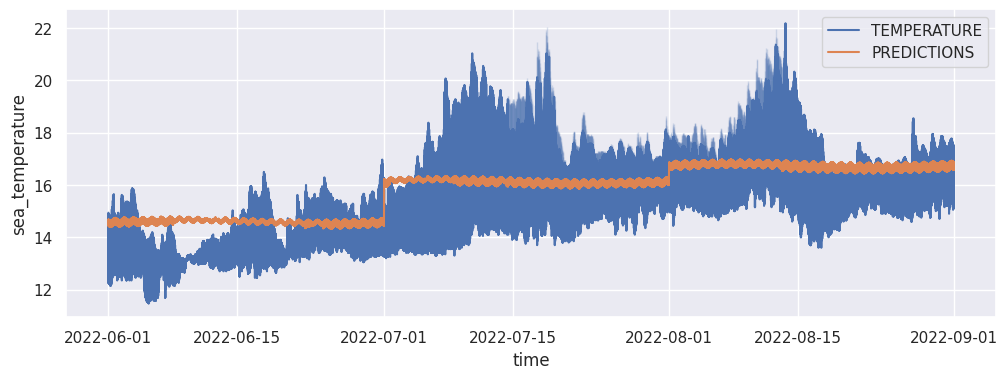

In [55]:
# plt.subplot(2,2,1)
sns.lineplot(x='time', y='sea_temperature', data=df8, label='TEMPERATURE')
sns.lineplot(x='time', y='predictions', data=df8, label='PREDICTIONS')

# plt.subplot(2,2,2)
# sns.lineplot(x='time', y='error_rate', data=df8)
# plt.axhline(1, linestyle='--')

# plt.subplot(2,2,3)
# sns.distplot(df8['error'])

# plt.subplot(2,2,4)
# sns.scatterplot(df8['predictions'], df8['error'])

<AxesSubplot: xlabel='time', ylabel='sea_temperature'>

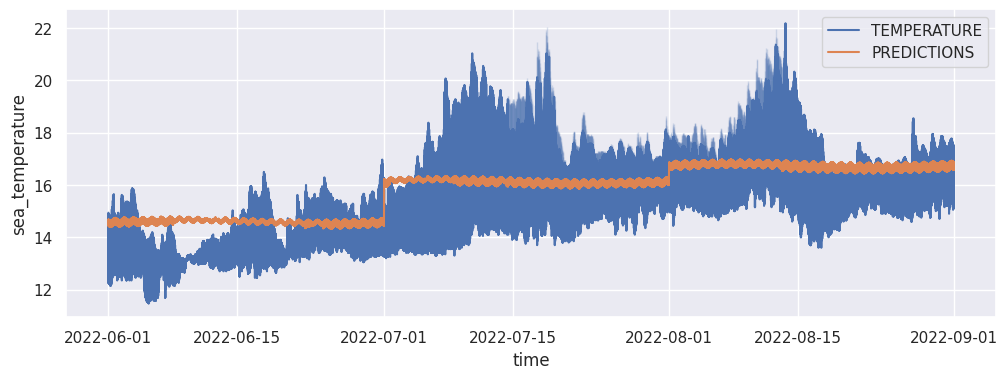

In [56]:
# plt.subplot(2,2,1)
sns.lineplot(x='time', y='sea_temperature', data=df8, label='TEMPERATURE')
sns.lineplot(x='time', y='predictions', data=df8, label='PREDICTIONS')